11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ReLU Training:
Epoch 1/100, Time: 22.67s, Loss: 0.1613, Val_Loss: 0.0551, Val_Acc: 0.9840
Epoch 2/100, Time: 28.39s, Loss: 0.0633, Val_Loss: 0.0298, Val_Acc: 0.9908
Epoch 3/100, Time: 4.74s, Loss: 0.0481, Val_Loss: 0.0291, Val_Acc: 0.9910
Epoch 4/100, Time: 4.98s, Loss: 0.0411, Val_Loss: 0.0258, Val_Acc: 0.9924
Epoch 5/100, Time: 4.93s, Loss: 0.0361, Val_Loss: 0.0253, Val_Acc: 0.9918
Epoch 6/100, Time: 4.77s, Loss: 0.0302, Val_Loss: 0.0242, Val_Acc: 0.9932
Epoch 7/100, Time: 5.47s, Loss: 0.0275, Val_Loss: 0.0268, Val_Acc: 0.9914
Epoch 8/100, Time: 4.76s, Loss: 0.0257, Val_Loss: 0.0225, Val_Acc: 0.9924
Epoch 9/100, Time: 4.60s, Loss: 0.0219, Val_Loss: 0.0237, Val_Acc: 0.9930
Epoch 10/100, Time: 5.44s, Loss: 0.0214, Val_Loss: 0.0254, Val_Acc: 0.9940
Epoch 11/100, Time: 4.91s, Loss: 0.0193, Val_Loss: 0.0202, Val_Acc: 0.9940
Epoch 12/100, Time: 5.39s, Loss: 0.0171, Val_Loss: 0.0180, Val_Acc: 0.9948
Epoch 13/100, Time: 5.15s, Loss: 0.0162, 

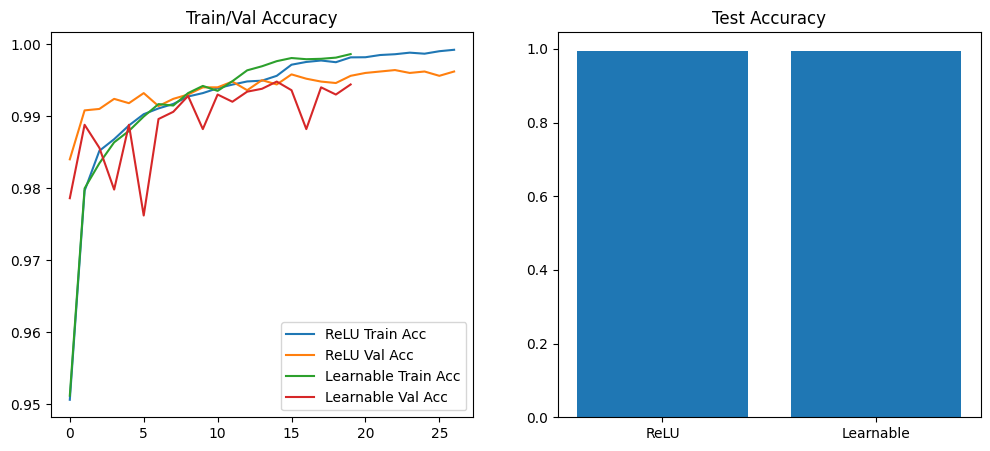

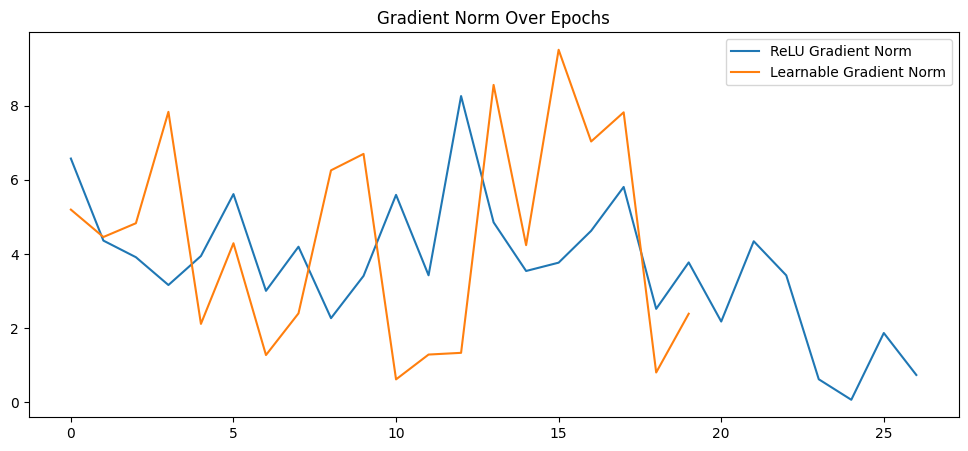

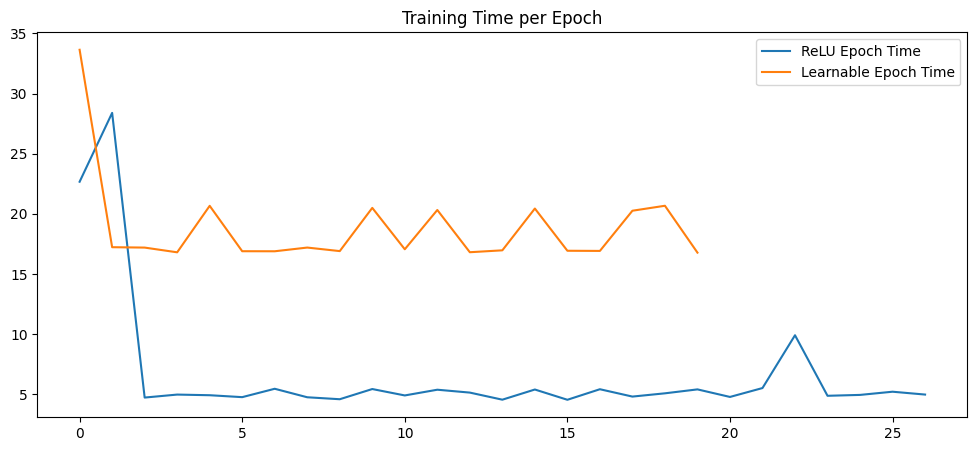

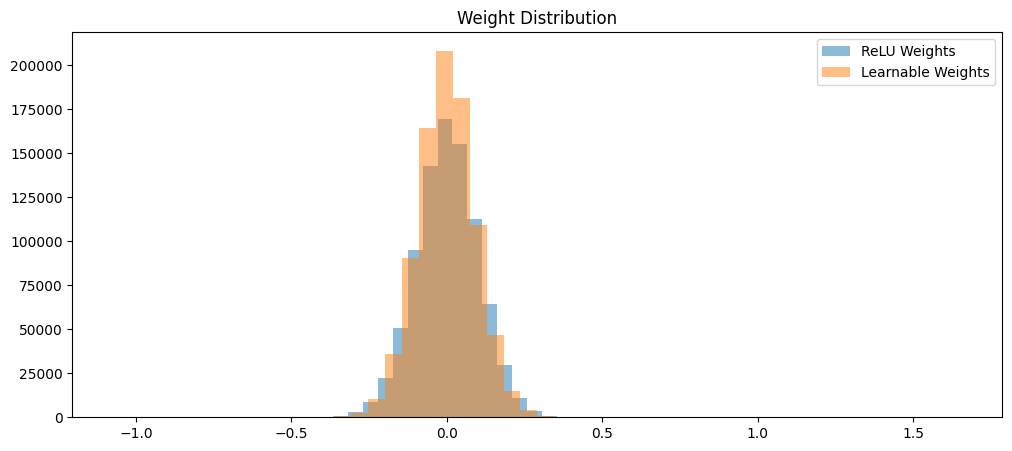

ReLU Model:
Test Accuracy: 0.9954
Sparsity: 0.0002
Total Training Time: 181.74s
Learnable Activation Model:
Test Accuracy: 0.9942
Sparsity: 0.0002
Total Training Time: 377.12s


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

# Set seeds
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
num_classes = 10
val_size = 5000

# Load MNIST data
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
# Expand dims for CNN (MNIST is grayscale, so 1 channel)
x_train_full = np.expand_dims(x_train_full, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Split train/val
x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]

# A learnable activation function implemented as a small MLP
class LearnableActivation(tf.keras.layers.Layer):
    def __init__(self, hidden_units=16):
        super(LearnableActivation, self).__init__()
        self.dense1 = tf.keras.layers.Dense(hidden_units, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        # Assuming inputs shape is (batch_size, features)
        # If we have multiple features, we apply the MLP to each feature independently.
        # Here we assume inputs is (batch_size, height, width, channels) for CNN layers.
        # We'll reshape, apply the MLP per channel and reshape back.
        shape = tf.shape(inputs)
        # Flatten spatial dimensions if necessary
        flat_inputs = tf.reshape(inputs, [shape[0], -1])

        # Apply MLP element-wise to each activation value:
        # We can map each scalar through the MLP by a trick:
        # If we treat the MLP as (batch, features) -> (batch, 1), we'd need to do this per feature.
        # Instead, we use tf.map_fn or just do a Dense layer broadcast approach.
        # Here, let's apply dense layers on each element separately using a loop or tf.vectorized_map.
        # This might be slow. Alternatively, we can treat the MLP as a universal approximator:
        # For simplicity and speed, consider a single dense applied feature-wise:

        # We'll process each element of flat_inputs individually:
        # (batch_size, n) -> flatten across batch and features -> (batch_size*n, 1)
        expanded = tf.expand_dims(flat_inputs, axis=-1)
        x = self.dense1(expanded)  # (batch_size*n, hidden_units)
        out = self.dense2(x)       # (batch_size*n, 1)
        out = tf.squeeze(out, axis=-1)  # (batch_size*n)

        # Reshape back to original shape
        out_reshaped = tf.reshape(out, shape)
        return out_reshaped

# Initializer
initializer = tf.keras.initializers.HeNormal()

# Build model function
def build_model(activation_func):
    inputs = tf.keras.Input(shape=(28,28,1))
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    if activation_func == 'relu':
        x = tf.keras.layers.Activation('relu')(x)
    else:
        x = activation_func(x)

    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if activation_func == 'relu':
        x = tf.keras.layers.Activation('relu')(x)
    else:
        x = activation_func(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if activation_func == 'relu':
        x = tf.keras.layers.Activation('relu')(x)
    else:
        x = activation_func(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if activation_func == 'relu':
        x = tf.keras.layers.Activation('relu')(x)
    else:
        x = activation_func(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if activation_func == 'relu':
        x = tf.keras.layers.Activation('relu')(x)
    else:
        x = activation_func(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Custom callback for timing and gradients
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Acc: {logs.get('val_accuracy',0):.4f}")

# Compute sparsity
def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

# Training for ReLU
print("ReLU Training:")
model_relu = build_model('relu')
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

callback_relu = CustomCallback()
callbacks_relu = [
    callback_relu,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_relu_best.keras", save_best_only=True, monitor='val_loss')
]

history_relu = model_relu.fit(x_train, y_train,
                              validation_data=(x_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=0,
                              callbacks=callbacks_relu)

test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
relu_sparsity = compute_sparsity(model_relu)

# Training for Learnable Activation
print("Learnable Activation Training:")
learnable_act_layer = LearnableActivation(hidden_units=16)
model_learn = build_model(learnable_act_layer)
model_learn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

callback_learn = CustomCallback()
callbacks_learn = [
    callback_learn,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("model_learn_best.keras", save_best_only=True, monitor='val_loss')
]

history_learn = model_learn.fit(x_train, y_train,
                                validation_data=(x_val, y_val),
                                epochs=epochs,
                                batch_size=batch_size,
                                verbose=0,
                                callbacks=callbacks_learn)

test_loss_learn, test_acc_learn = model_learn.evaluate(x_test, y_test, verbose=0)
learn_sparsity = compute_sparsity(model_learn)

model_relu.save("model_relu_final.keras")
model_learn.save("model_learn_final.keras")

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_relu.history['accuracy'], label='ReLU Train Acc')
plt.plot(history_relu.history['val_accuracy'], label='ReLU Val Acc')
plt.plot(history_learn.history['accuracy'], label='Learnable Train Acc')
plt.plot(history_learn.history['val_accuracy'], label='Learnable Val Acc')
plt.title('Train/Val Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['ReLU', 'Learnable'], [test_acc_relu, test_acc_learn])
plt.title('Test Accuracy')
plt.show()

# Plot gradient norms
plt.figure(figsize=(12,5))
plt.plot(callback_relu.gradient_norms, label='ReLU Gradient Norm')
plt.plot(callback_learn.gradient_norms, label='Learnable Gradient Norm')
plt.title('Gradient Norm Over Epochs')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(12,5))
plt.plot(callback_relu.train_times, label='ReLU Epoch Time')
plt.plot(callback_learn.train_times, label='Learnable Epoch Time')
plt.title('Training Time per Epoch')
plt.legend()
plt.show()

# Weight distributions
relu_weights = np.concatenate([w.numpy().flatten() for w in model_relu.trainable_variables])
learn_weights = np.concatenate([w.numpy().flatten() for w in model_learn.trainable_variables])

plt.figure(figsize=(12,5))
plt.hist(relu_weights, bins=50, alpha=0.5, label='ReLU Weights')
plt.hist(learn_weights, bins=50, alpha=0.5, label='Learnable Weights')
plt.title('Weight Distribution')
plt.legend()
plt.show()

print("ReLU Model:")
print(f"Test Accuracy: {test_acc_relu:.4f}")
print(f"Sparsity: {relu_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

print("Learnable Activation Model:")
print(f"Test Accuracy: {test_acc_learn:.4f}")
print(f"Sparsity: {learn_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_learn.train_times):.2f}s")


# Cifar-10

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
ReLU Training:
Epoch 1/100, Time: 26.59s, Loss: 1.5888, Val_Loss: 1.1784, Val_Acc: 0.5770
Epoch 2/100, Time: 9.80s, Loss: 1.1037, Val_Loss: 0.8649, Val_Acc: 0.6892
Epoch 3/100, Time: 6.50s, Loss: 0.9140, Val_Loss: 1.0376, Val_Acc: 0.6514
Epoch 4/100, Time: 6.65s, Loss: 0.8051, Val_Loss: 0.6948, Val_Acc: 0.7548
Epoch 5/100, Time: 10.34s, Loss: 0.7273, Val_Loss: 0.6880, Val_Acc: 0.7596
Epoch 6/100, Time: 10.31s, Loss: 0.6685, Val_Loss: 0.7361, Val_Acc: 0.7506
Epoch 7/100, Time: 9.94s, Loss: 0.6170, Val_Loss: 0.6623, Val_Acc: 0.7734
Epoch 8/100, Time: 6.84s, Loss: 0.5746, Val_Loss: 0.5789, Val_Acc: 0.8004
Epoch 9/100, Time: 10.73s, Loss: 0.5345, Val_Loss: 0.5252, Val_Acc: 0.8128
Epoch 10/100, Time: 6.34s, Loss: 0.5016, Val_Loss: 0.6191, Val_Acc: 0.7984
Epoch 11/100, Time: 10.41s, Loss: 0.4746, Val_Loss: 0.5600, Val_Acc: 0.8106
Epoch 12/100, Time: 10.68s, Loss: 0.4443, Val_Loss: 0.5638, Val_Acc: 0.8144
Epoch 13/100, Time: 6.60s, Loss: 0.

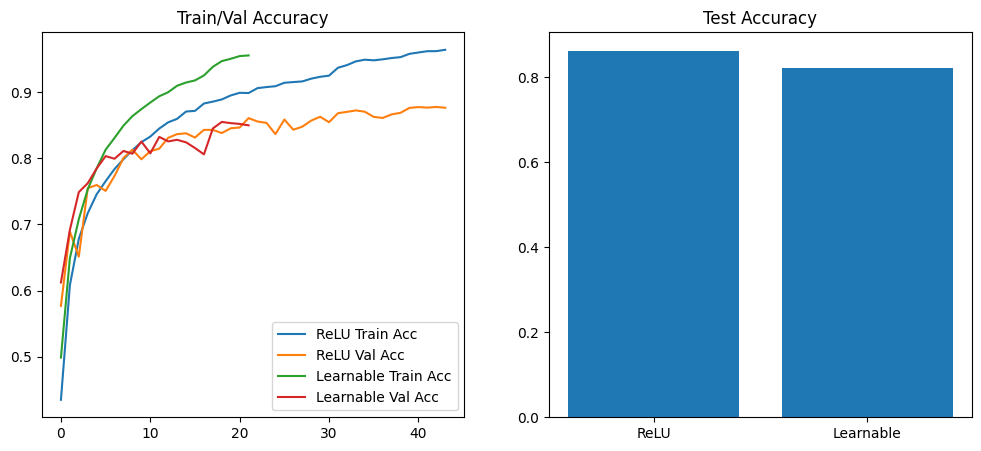

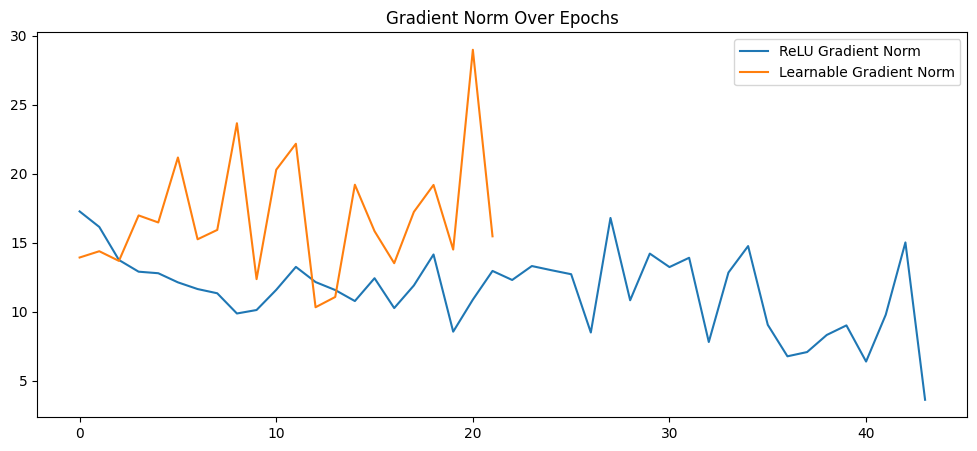

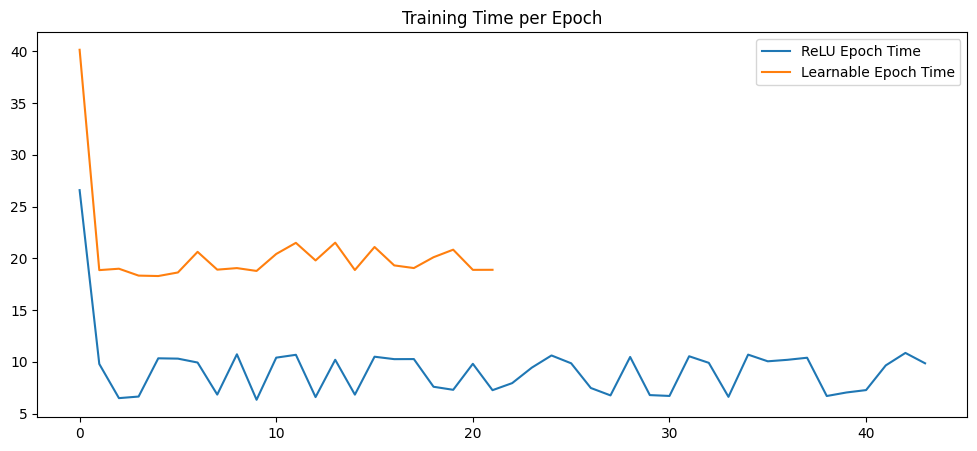

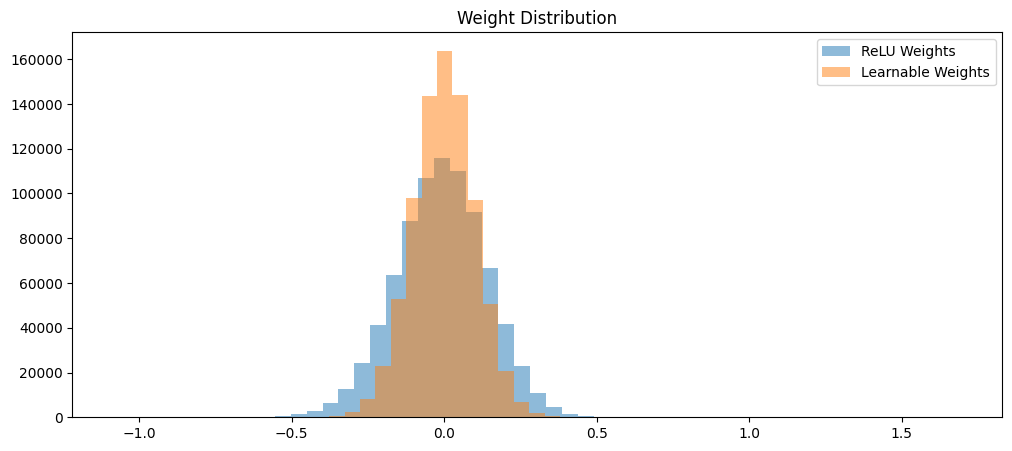

ReLU Model:
Test Accuracy: 0.8621
Sparsity: 0.0001
Total Training Time: 407.69s
Learnable Activation Model:
Test Accuracy: 0.8203
Sparsity: 0.0001
Total Training Time: 450.93s


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

# Set seeds
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
num_classes = 10
val_size = 5000

# Load CIFAR-10 data
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Split train/val
x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]

# A learnable activation function implemented as a small MLP
class LearnableActivation(tf.keras.layers.Layer):
    def __init__(self, hidden_units=16):
        super(LearnableActivation, self).__init__()
        self.dense1 = tf.keras.layers.Dense(hidden_units, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        # Inputs shape: (batch_size, height, width, channels)
        shape = tf.shape(inputs)
        flat_inputs = tf.reshape(inputs, [shape[0], -1])  # flatten spatial+channel dims

        # Apply MLP to each element
        expanded = tf.expand_dims(flat_inputs, axis=-1)  # (batch_size, features, 1)
        x = self.dense1(expanded)  # (batch_size, features, hidden_units)
        out = self.dense2(x)       # (batch_size, features, 1)
        out = tf.squeeze(out, axis=-1)  # (batch_size, features)

        # Reshape back
        out_reshaped = tf.reshape(out, shape)
        return out_reshaped

# Initializer
initializer = tf.keras.initializers.HeNormal()

# Build model function
def build_model(activation_func):
    # A slightly deeper model suited for CIFAR-10
    inputs = tf.keras.Input(shape=(32,32,3))
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation_func(x) if activation_func != 'relu' else tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation_func(x) if activation_func != 'relu' else tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation_func(x) if activation_func != 'relu' else tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation_func(x) if activation_func != 'relu' else tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation_func(x) if activation_func != 'relu' else tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation_func(x) if activation_func != 'relu' else tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation_func(x) if activation_func != 'relu' else tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Custom callback for timing and gradients
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Acc: {logs.get('val_accuracy',0):.4f}")

# Compute sparsity
def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

# Training for ReLU
print("ReLU Training:")
model_relu = build_model('relu')
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

callback_relu = CustomCallback()
callbacks_relu = [
    callback_relu,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    tf.keras.callbacks.ModelCheckpoint("model_relu_best.keras", save_best_only=True, monitor='val_loss')
]

history_relu = model_relu.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    callbacks=callbacks_relu
)

test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
relu_sparsity = compute_sparsity(model_relu)

# Training for Learnable Activation
print("Learnable Activation Training:")
learnable_act_layer = LearnableActivation(hidden_units=16)
model_learn = build_model(learnable_act_layer)
model_learn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

callback_learn = CustomCallback()
callbacks_learn = [
    callback_learn,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    tf.keras.callbacks.ModelCheckpoint("model_learn_best.keras", save_best_only=True, monitor='val_loss')
]

history_learn = model_learn.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    callbacks=callbacks_learn
)

test_loss_learn, test_acc_learn = model_learn.evaluate(x_test, y_test, verbose=0)
learn_sparsity = compute_sparsity(model_learn)

model_relu.save("model_relu_final_cifar10.keras")
model_learn.save("model_learn_final_cifar10.keras")

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_relu.history['accuracy'], label='ReLU Train Acc')
plt.plot(history_relu.history['val_accuracy'], label='ReLU Val Acc')
plt.plot(history_learn.history['accuracy'], label='Learnable Train Acc')
plt.plot(history_learn.history['val_accuracy'], label='Learnable Val Acc')
plt.title('Train/Val Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['ReLU', 'Learnable'], [test_acc_relu, test_acc_learn])
plt.title('Test Accuracy')
plt.show()

# Plot gradient norms
plt.figure(figsize=(12,5))
plt.plot(callback_relu.gradient_norms, label='ReLU Gradient Norm')
plt.plot(callback_learn.gradient_norms, label='Learnable Gradient Norm')
plt.title('Gradient Norm Over Epochs')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(12,5))
plt.plot(callback_relu.train_times, label='ReLU Epoch Time')
plt.plot(callback_learn.train_times, label='Learnable Epoch Time')
plt.title('Training Time per Epoch')
plt.legend()
plt.show()

# Weight distributions
relu_weights = np.concatenate([w.numpy().flatten() for w in model_relu.trainable_variables])
learn_weights = np.concatenate([w.numpy().flatten() for w in model_learn.trainable_variables])

plt.figure(figsize=(12,5))
plt.hist(relu_weights, bins=50, alpha=0.5, label='ReLU Weights')
plt.hist(learn_weights, bins=50, alpha=0.5, label='Learnable Weights')
plt.title('Weight Distribution')
plt.legend()
plt.show()

print("ReLU Model:")
print(f"Test Accuracy: {test_acc_relu:.4f}")
print(f"Sparsity: {relu_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

print("Learnable Activation Model:")
print(f"Test Accuracy: {test_acc_learn:.4f}")
print(f"Sparsity: {learn_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_learn.train_times):.2f}s")


# More Complex MLP

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

# Set seeds
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
num_classes = 10
val_size = 5000
weight_decay = 1e-4  # L2 regularization factor

# Load CIFAR-10 data
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Split train/val
x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]

# A more complex learnable activation function
# Multiple layers, GELU activation, and L2 regularization
class LearnableActivation(tf.keras.layers.Layer):
    def __init__(self, hidden_units=64, wd=1e-4):
        super(LearnableActivation, self).__init__()
        self.dense1 = tf.keras.layers.Dense(
            hidden_units,
            activation='gelu',
            kernel_initializer='he_normal',
            kernel_regularizer=tf.keras.regularizers.l2(wd)
        )
        self.dense2 = tf.keras.layers.Dense(
            hidden_units // 2,
            activation='gelu',
            kernel_initializer='he_normal',
            kernel_regularizer=tf.keras.regularizers.l2(wd)
        )
        self.dense3 = tf.keras.layers.Dense(
            1,
            activation=None,
            kernel_initializer='he_normal',
            kernel_regularizer=tf.keras.regularizers.l2(wd)
        )

    def call(self, inputs):
        # Inputs shape: (batch_size, height, width, channels)
        shape = tf.shape(inputs)
        flat_inputs = tf.reshape(inputs, [shape[0], -1])  # flatten spatial+channel dims

        expanded = tf.expand_dims(flat_inputs, axis=-1)  # (batch_size, features, 1)
        x = self.dense1(expanded)  # (batch_size, features, hidden_units)
        x = self.dense2(x)         # (batch_size, features, hidden_units/2)
        out = self.dense3(x)       # (batch_size, features, 1)
        out = tf.squeeze(out, axis=-1)  # (batch_size, features)

        # Reshape back
        out_reshaped = tf.reshape(out, shape)
        return out_reshaped

# Initializer
initializer = tf.keras.initializers.HeNormal()
regularizer = tf.keras.regularizers.l2(weight_decay)

# Build model function with L2 regularization applied to layers
def build_model(activation_func):
    inputs = tf.keras.Input(shape=(32,32,3))
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer,
                               kernel_regularizer=regularizer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation_func(x) if activation_func != 'relu' else tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer,
                               kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation_func(x) if activation_func != 'relu' else tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer,
                               kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation_func(x) if activation_func != 'relu' else tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer,
                               kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation_func(x) if activation_func != 'relu' else tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer=initializer,
                               kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation_func(x) if activation_func != 'relu' else tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer=initializer,
                               kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation_func(x) if activation_func != 'relu' else tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = activation_func(x) if activation_func != 'relu' else tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizer)(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Custom callback for timing and gradients
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Acc: {logs.get('val_accuracy',0):.4f}")

def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

# Training for ReLU (baseline)
print("ReLU Training:")
model_relu = build_model('relu')
model_relu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

callback_relu = CustomCallback()
callbacks_relu = [
    callback_relu,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    tf.keras.callbacks.ModelCheckpoint("model_relu_best_cifar10.keras", save_best_only=True, monitor='val_loss')
]

history_relu = model_relu.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    callbacks=callbacks_relu
)

test_loss_relu, test_acc_relu = model_relu.evaluate(x_test, y_test, verbose=0)
relu_sparsity = compute_sparsity(model_relu)

# Training for Learnable Activation
print("Learnable Activation Training (More complex MLP + L2 reg):")
learnable_act_layer = LearnableActivation(hidden_units=64, wd=weight_decay)
model_learn = build_model(learnable_act_layer)
model_learn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

callback_learn = CustomCallback()
callbacks_learn = [
    callback_learn,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    tf.keras.callbacks.ModelCheckpoint("model_learn_best_cifar10.keras", save_best_only=True, monitor='val_loss')
]

history_learn = model_learn.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    callbacks=callbacks_learn
)

test_loss_learn, test_acc_learn = model_learn.evaluate(x_test, y_test, verbose=0)
learn_sparsity = compute_sparsity(model_learn)

model_relu.save("model_relu_final_cifar10.keras")
model_learn.save("model_learn_final_cifar10.keras")

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_relu.history['accuracy'], label='ReLU Train Acc')
plt.plot(history_relu.history['val_accuracy'], label='ReLU Val Acc')
plt.plot(history_learn.history['accuracy'], label='Learnable Train Acc')
plt.plot(history_learn.history['val_accuracy'], label='Learnable Val Acc')
plt.title('Train/Val Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.bar(['ReLU', 'Learnable'], [test_acc_relu, test_acc_learn])
plt.title('Test Accuracy')
plt.show()

# Plot gradient norms
plt.figure(figsize=(12,5))
plt.plot(callback_relu.gradient_norms, label='ReLU Gradient Norm')
plt.plot(callback_learn.gradient_norms, label='Learnable Gradient Norm')
plt.title('Gradient Norm Over Epochs')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(12,5))
plt.plot(callback_relu.train_times, label='ReLU Epoch Time')
plt.plot(callback_learn.train_times, label='Learnable Epoch Time')
plt.title('Training Time per Epoch')
plt.legend()
plt.show()

# Weight distributions
relu_weights = np.concatenate([w.numpy().flatten() for w in model_relu.trainable_variables])
learn_weights = np.concatenate([w.numpy().flatten() for w in model_learn.trainable_variables])

plt.figure(figsize=(12,5))
plt.hist(relu_weights, bins=50, alpha=0.5, label='ReLU Weights')
plt.hist(learn_weights, bins=50, alpha=0.5, label='Learnable Weights')
plt.title('Weight Distribution')
plt.legend()
plt.show()

print("ReLU Model:")
print(f"Test Accuracy: {test_acc_relu:.4f}")
print(f"Sparsity: {relu_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

print("Learnable Activation Model (Complex MLP + L2):")
print(f"Test Accuracy: {test_acc_learn:.4f}")
print(f"Sparsity: {learn_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_learn.train_times):.2f}s")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
ReLU Training:
Epoch 1/100, Time: 35.54s, Loss: 1.6926, Val_Loss: 1.3061, Val_Acc: 0.5942
Epoch 2/100, Time: 8.60s, Loss: 1.2220, Val_Loss: 1.0411, Val_Acc: 0.6846
Epoch 3/100, Time: 10.04s, Loss: 1.0632, Val_Loss: 0.9410, Val_Acc: 0.7242
Epoch 4/100, Time: 5.97s, Loss: 0.9772, Val_Loss: 0.9069, Val_Acc: 0.7418
Epoch 5/100, Time: 5.48s, Loss: 0.9102, Val_Loss: 1.0899, Val_Acc: 0.7014
Epoch 6/100, Time: 5.64s, Loss: 0.8655, Val_Loss: 0.9577, Val_Acc: 0.7436
Epoch 7/100, Time: 5.31s, Loss: 0.8310, Val_Loss: 1.0117, Val_Acc: 0.7364
Epoch 8/100, Time: 5.59s, Loss: 0.8025, Val_Loss: 0.8637, Val_Acc: 0.7778
Epoch 9/100, Time: 5.57s, Loss: 0.7757, Val_Loss: 0.7939, Val_Acc: 0.8114
Epoch 10/100, Time: 10.52s, Loss: 0.7630, Val_Loss: 0.7551, Val_Acc: 0.8176
Epoch 11/100, Time: 5.45s, Loss: 0.7394, Val_Loss: 0.8410, Val_Acc: 0.7994
Epoch 12/100, Time: 5.69s, Loss: 0.7245, Val_Loss: 0.7501, Val_Acc: 0.8292
Epoch 13/100, Time: 10.12s, Loss: 0.7

ResourceExhaustedError: Exception encountered when calling Dense.call().

[1m{{function_node __wrapped__RealDiv_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:RealDiv] name: [0m

Arguments received by Dense.call():
  • inputs=tf.Tensor(shape=(64, 16384, 64), dtype=float32)
  • training=True

In [2]:
print("ReLU Model:")
print(f"Test Accuracy: {test_acc_relu:.4f}")
print(f"Sparsity: {relu_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_relu.train_times):.2f}s")

ReLU Model:
Test Accuracy: 0.8770
Sparsity: 0.0002
Total Training Time: 695.38s


Physical devices cannot be modified after being initialized
Channel-Wise Learnable Activation Training:
Epoch 1/100, Time: 41.44s, Loss: 1.8037, Val_Loss: 1.2840, Val_Acc: 0.6412
Epoch 2/100, Time: 16.06s, Loss: 1.3450, Val_Loss: 1.1273, Val_Acc: 0.6940
Epoch 3/100, Time: 9.18s, Loss: 1.2389, Val_Loss: 1.1502, Val_Acc: 0.6906
Epoch 4/100, Time: 9.84s, Loss: 1.1764, Val_Loss: 1.1522, Val_Acc: 0.6926
Epoch 5/100, Time: 10.21s, Loss: 1.1396, Val_Loss: 1.0724, Val_Acc: 0.7288
Epoch 6/100, Time: 9.20s, Loss: 1.1098, Val_Loss: 1.0825, Val_Acc: 0.7244
Epoch 7/100, Time: 10.46s, Loss: 1.0882, Val_Loss: 1.0252, Val_Acc: 0.7448
Epoch 8/100, Time: 9.05s, Loss: 1.0710, Val_Loss: 1.0260, Val_Acc: 0.7468
Epoch 9/100, Time: 10.02s, Loss: 1.0478, Val_Loss: 1.0197, Val_Acc: 0.7532
Epoch 10/100, Time: 10.29s, Loss: 1.0406, Val_Loss: 0.9908, Val_Acc: 0.7660
Epoch 11/100, Time: 10.65s, Loss: 1.0263, Val_Loss: 1.0011, Val_Acc: 0.7682
Epoch 12/100, Time: 10.48s, Loss: 1.0171, Val_Loss: 0.9890, Val_Acc: 0.77

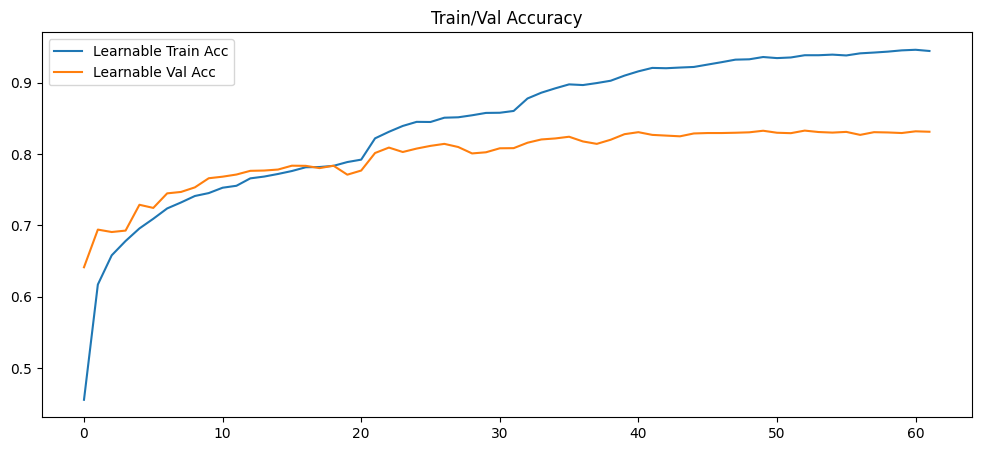

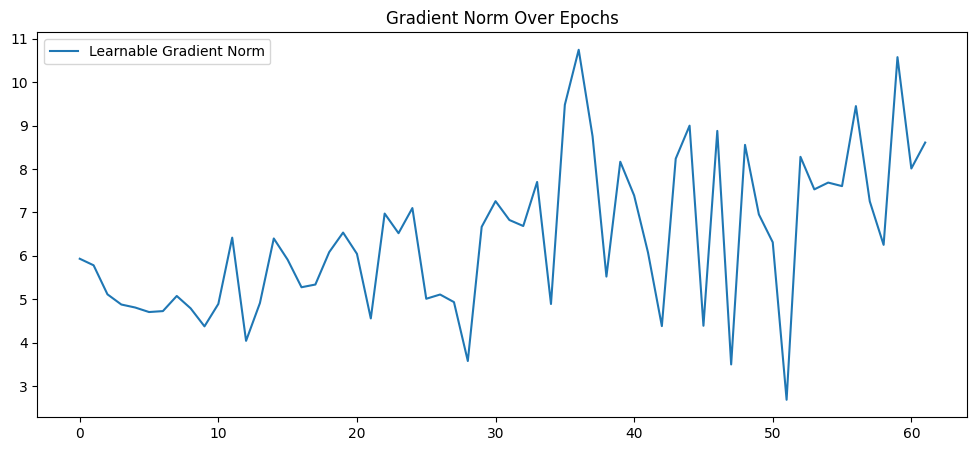

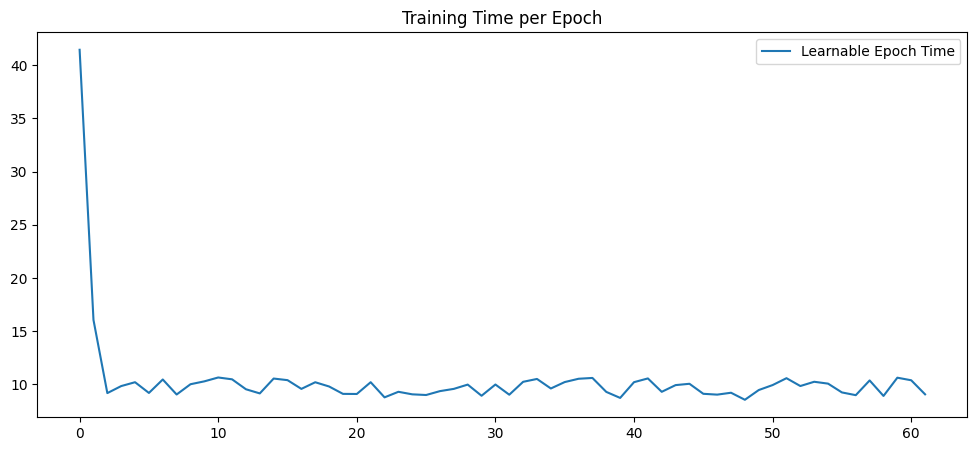

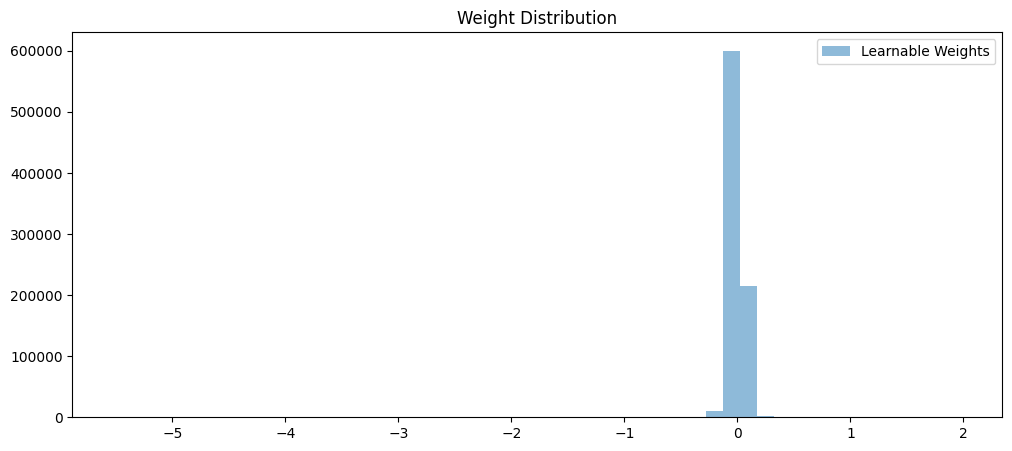

Learnable Activation Model:
Test Accuracy: 0.8214
Sparsity: 0.0052
Total Training Time: 641.12s


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

# Attempt to enable dynamic memory growth on GPU if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameters
batch_size = 32  # Reduced from 64 to help with memory
learning_rate = 0.001
epochs = 100
num_classes = 10
val_size = 5000
weight_decay = 1e-4  # L2 regularization factor

# Load CIFAR-10 data
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train_full = tf.keras.utils.to_categorical(y_train_full, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Split train/val
x_val = x_train_full[:val_size]
y_val = y_train_full[:val_size]
x_train = x_train_full[val_size:]
y_train = y_train_full[val_size:]

class ChannelWiseLearnableActivation(tf.keras.layers.Layer):
    def __init__(self, hidden_units=16, wd=1e-4):
        super(ChannelWiseLearnableActivation, self).__init__()
        self.hidden_units = hidden_units
        self.wd = wd

    def build(self, input_shape):
        c = input_shape[-1]
        self.dense1 = tf.keras.layers.Dense(
            self.hidden_units,
            activation='relu',
            kernel_initializer='he_normal',
            kernel_regularizer=tf.keras.regularizers.l2(self.wd)
        )
        self.dense2 = tf.keras.layers.Dense(
            c,
            activation='sigmoid',
            kernel_initializer='he_normal',
            kernel_regularizer=tf.keras.regularizers.l2(self.wd)
        )
        super().build(input_shape)

    def call(self, inputs):
        # inputs: (batch, h, w, c)
        x_mean = tf.reduce_mean(inputs, axis=[1, 2])  # (batch, c)
        x_hidden = self.dense1(x_mean)  # (batch, hidden_units)
        scale = self.dense2(x_hidden)   # (batch, c)
        scale = tf.reshape(scale, [-1, 1, 1, tf.shape(scale)[-1]])
        return inputs * scale

initializer = tf.keras.initializers.HeNormal()
regularizer = tf.keras.regularizers.l2(weight_decay)

def build_model():
    inputs = tf.keras.Input(shape=(32,32,3))
    # Block 1
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer,
                               kernel_regularizer=regularizer)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = ChannelWiseLearnableActivation(hidden_units=16, wd=weight_decay)(x)

    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_initializer=initializer,
                               kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = ChannelWiseLearnableActivation(hidden_units=16, wd=weight_decay)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # Block 2
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer,
                               kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = ChannelWiseLearnableActivation(hidden_units=16, wd=weight_decay)(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer=initializer,
                               kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = ChannelWiseLearnableActivation(hidden_units=16, wd=weight_decay)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # Block 3
    x = tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer=initializer,
                               kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = ChannelWiseLearnableActivation(hidden_units=16, wd=weight_decay)(x)

    x = tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer=initializer,
                               kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = ChannelWiseLearnableActivation(hidden_units=16, wd=weight_decay)(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # Dense layer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizer)(x)
    model = tf.keras.Model(inputs, outputs)
    return model

class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_times = []
        self.start_time = time.time()
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_time = end_time - self.start_time
        self.train_times.append(epoch_time)
        self.start_time = end_time
        x_sample, y_sample = x_train[:batch_size], y_train[:batch_size]
        with tf.GradientTape() as tape:
            preds = self.model(x_sample, training=True)
            loss_value = tf.keras.losses.categorical_crossentropy(y_sample, preds)
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        norm = np.mean([tf.norm(g).numpy() for g in grads if g is not None])
        self.gradient_norms.append(norm)
        print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, "
              f"Loss: {logs.get('loss',0):.4f}, Val_Loss: {logs.get('val_loss',0):.4f}, "
              f"Val_Acc: {logs.get('val_accuracy',0):.4f}")

def compute_sparsity(model):
    weights = []
    for w in model.trainable_variables:
        weights.extend(w.numpy().flatten())
    weights = np.array(weights)
    return np.mean(np.abs(weights) < 1e-5)

# Train the Learnable Activation model
print("Channel-Wise Learnable Activation Training:")
model_learn = build_model()
model_learn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

callback_learn = CustomCallback()
callbacks_learn = [
    callback_learn,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    tf.keras.callbacks.ModelCheckpoint("model_learn_best_cifar10.keras", save_best_only=True, monitor='val_loss')
]

history_learn = model_learn.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    callbacks=callbacks_learn
)

test_loss_learn, test_acc_learn = model_learn.evaluate(x_test, y_test, verbose=0)
learn_sparsity = compute_sparsity(model_learn)

model_learn.save("model_learn_final_cifar10.keras")

# Plot accuracy
plt.figure(figsize=(12,5))
plt.plot(history_learn.history['accuracy'], label='Learnable Train Acc')
plt.plot(history_learn.history['val_accuracy'], label='Learnable Val Acc')
plt.title('Train/Val Accuracy')
plt.legend()
plt.show()

# Plot gradient norms
plt.figure(figsize=(12,5))
plt.plot(callback_learn.gradient_norms, label='Learnable Gradient Norm')
plt.title('Gradient Norm Over Epochs')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(12,5))
plt.plot(callback_learn.train_times, label='Learnable Epoch Time')
plt.title('Training Time per Epoch')
plt.legend()
plt.show()

# Weight distributions
learn_weights = np.concatenate([w.numpy().flatten() for w in model_learn.trainable_variables])
plt.figure(figsize=(12,5))
plt.hist(learn_weights, bins=50, alpha=0.5, label='Learnable Weights')
plt.title('Weight Distribution')
plt.legend()
plt.show()

print("Learnable Activation Model:")
print(f"Test Accuracy: {test_acc_learn:.4f}")
print(f"Sparsity: {learn_sparsity:.4f}")
print(f"Total Training Time: {sum(callback_learn.train_times):.2f}s")
